In [43]:
from importlib import reload
import numpy as np
from sklearn import cluster
import mido
import os
from scipy.sparse import csc_matrix, csr_matrix
import pickle
import pretty_midi
import sys
import copy
from collections import namedtuple
import timeit
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm

In [44]:
# import modules, including a reload statement so that they can be reimported after a change to the methods 
import src.midi_utils as midi_utils
reload(midi_utils)

import src.data as data
reload(data)

import src.models as models
reload(models)

import src.ml_classes as ml_classes
reload(ml_classes)

<module 'src.ml_classes' from '/storage/781-piano-autoencoder/src/ml_classes.py'>

In [45]:
files = [file for file in os.scandir('training_data/midi_val_8/')]
pm = pretty_midi.PrettyMIDI(files[np.random.randint(len(files))].path)
max_start = pm.instruments[0].notes[-1].start
notes = np.array([[note.start/ (2.5*max_start), note.pitch/127, (note.velocity - 21) / (127 * 1.5)] for note in pm.instruments[0].notes])

## Functions for splitting midi files into example-length lists of notes, for clustering notes into two groups, and for splitting pm objects into hands

In [126]:
def divide_pm2note_examples(pm, beats_per_ex=8, sub_beats = 2):
    """returns a list of lists of notes, dividing a pm into examples"""
    beat_length = pm.get_beats()[1]
    sub_beat_length = beat_length / sub_beats
    sub_beats_per_ex = sub_beats * beats_per_ex
    n_examples = len(pm.get_beats()) // beats_per_ex + 2
    example = 0
    examples = [[] for _ in range(n_examples)]
    for note in pm.instruments[0].notes:
        # if the note start falls after the start time of the next example, example index += 1
        if note.start > pm.get_beats()[example * beats_per_ex] + pm.get_beats()[1] / sub_beats * (beats_per_ex * sub_beats - 1):
            example += 1
        examples[example].append(note)
    return examples

def divide_notes2hands(ex, duration_scale=0.1, pitch_scale=1, velocity_scale=0.5, range_init=False):
    """use kmeans to cluster notes into LH and RH
    
    Arguments:
    ex -- list of notes (pretty midi format)
    *_scale -- target range of variable, controlling importance of that variable for kmeans
    
    Notes:
    if duration_scale is too large (much over 0.2), then kmeans will start to prioritize
    time as the factor used to cluster the groups. This will then not split according to LH and RH.
    
    """
    # get duration of example
    duration = ex[-1].start - ex[0].start
    # get array of note information
    notes = np.array([[note.start / duration * duration_scale, note.pitch/127 * pitch_scale,
                       (note.velocity - 21) / 127 * velocity_scale] for note in ex])
    highest_idx = np.argmax(notes[:,1])
    lowest_idx = np.argmin(notes[:,1])
    if range_init:
        init = np.array([notes[highest_idx,:], notes[lowest_idx,:]])
        kmeans = cluster.KMeans(n_clusters=2, init=init).fit(notes)
    else:
        kmeans = cluster.KMeans(n_clusters=2).fit(notes)
    
    RH_id = kmeans.labels_[highest_idx]
    LH_id = kmeans.labels_[lowest_idx]
    assert RH_id != LH_id, "highest and lowest notes have been assigned to the same cluster!"
    RH_notes = [note for note, label in zip(ex, kmeans.labels_) if label == RH_id]
    LH_notes = [note for note, label in zip(ex, kmeans.labels_) if label == LH_id]
    return LH_notes, RH_notes

def divide_pm2hands(pm):
    """given a pm, return two pms, one for each hand (hopefully)"""
    examples = divide_pm2note_examples(pm)
    LH_notes = []
    RH_notes = []
    for ex in examples:
        lh, rh = divide_notes2hands(ex)
        LH_notes.extend(lh)
        RH_notes.extend(rh)
    LH_pm = pm
    RH_pm = copy.deepcopy(pm)
    LH_pm.instruments[0].notes = LH_notes
    RH_pm.instruments[0].notes = RH_notes
    return LH_pm, RH_pm

## Test out some different clustering methods

In [49]:
# get some random examples for clustering
examples = []
for file in tqdm(files):
    pm = pretty_midi.PrettyMIDI(files[np.random.randint(len(files))].path)
    f_examples = divide_pm(pm)
    examples.append(f_examples[np.random.randint(len(f_examples))])

100%|██████████| 12/12 [00:59<00:00,  4.95s/it]


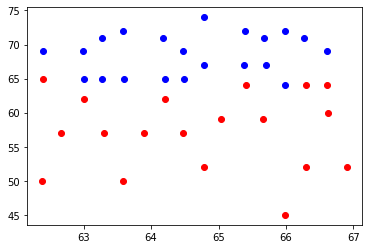

In [131]:
# test out clustering function
lh, rh = divide_notes2hands(examples[np.random.randint(len(examples))], range_init=False)
plt.scatter([note.start for note in lh], [note.pitch for note in lh], color='red')
plt.scatter([note.start for note in rh], [note.pitch for note in rh], color='blue')

4.5062500000000085
4.469375000000003
2.4481249999999974
3.776041666666657
4.046026098958322
4.458749999999998
4.16625
4.5062500000000085
4.7450000000000045
4.460624999999993
4.185625000000002
4.495625000000018


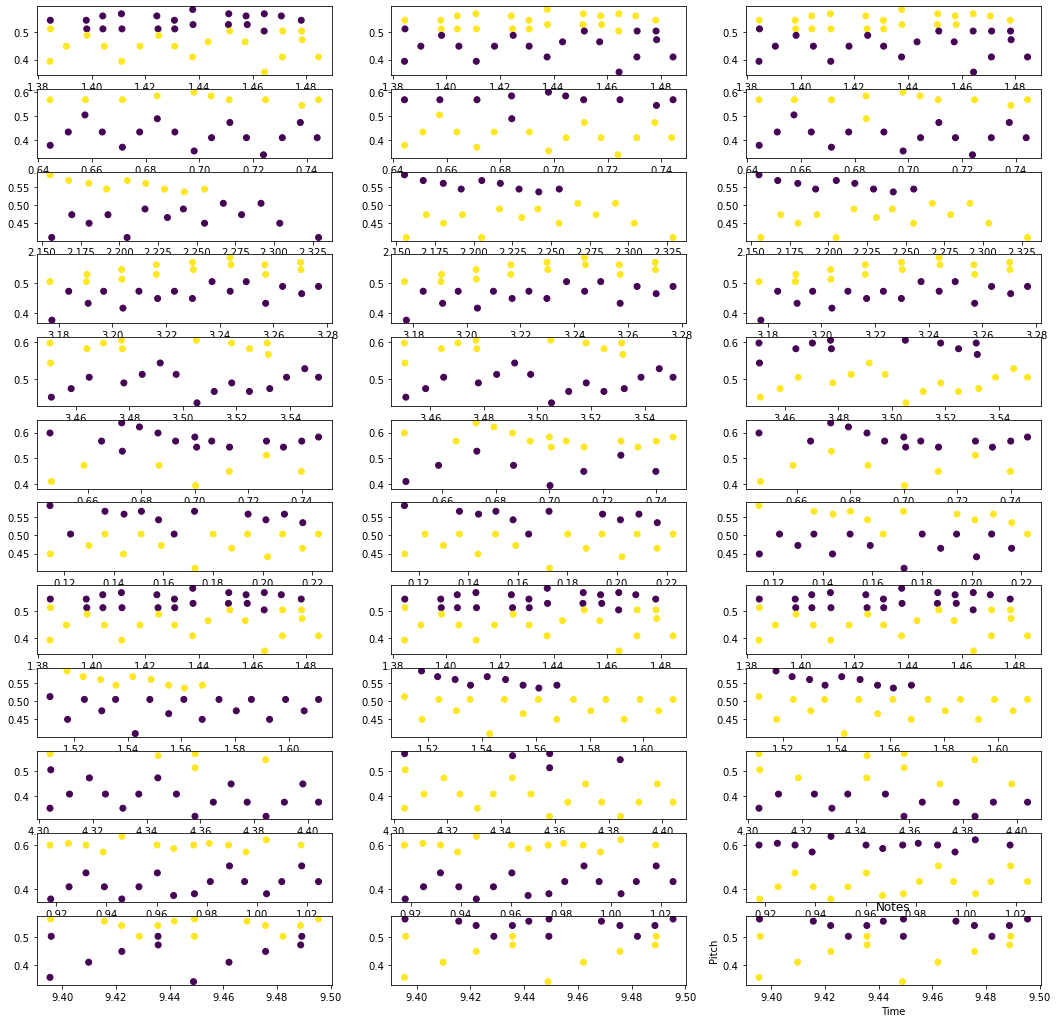

In [133]:
# Test out a few different clustering algorithms on example length note sequences
# set up scaling for axes
duration_scale=0.1
pitch_scale=1
velocity_scale=0.5

fig, ax = plt.subplots(nrows=len(examples),ncols=3, figsize=(18,18))
# plt.yscale('log')
for i, ex in enumerate(examples):
    duration = ex[-1].start - ex[0].start
    print(duration)
    notes = np.array([[note.start / duration * duration_scale, note.pitch/127 * pitch_scale,
                       (note.velocity - 21) / 127 * velocity_scale] for note in ex])
    
    kmeans = cluster.KMeans(n_clusters=2).fit(notes)
    spectral = cluster.SpectralClustering(n_clusters=2, assign_labels='discretize').fit(notes)
    ag = cluster.AgglomerativeClustering(2).fit(notes)
    
    ax[i,0].scatter([n[0] for n in notes], [n[1] for n in notes], c=ag.labels_)
    ax[i,1].scatter([n[0] for n in notes], [n[1] for n in notes], c=kmeans.labels_)
    ax[i,2].scatter([n[0] for n in notes], [n[1] for n in notes], c=spectral.labels_)
    plt.title('Notes')
    plt.xlabel('Time')
    plt.ylabel('Pitch')

100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


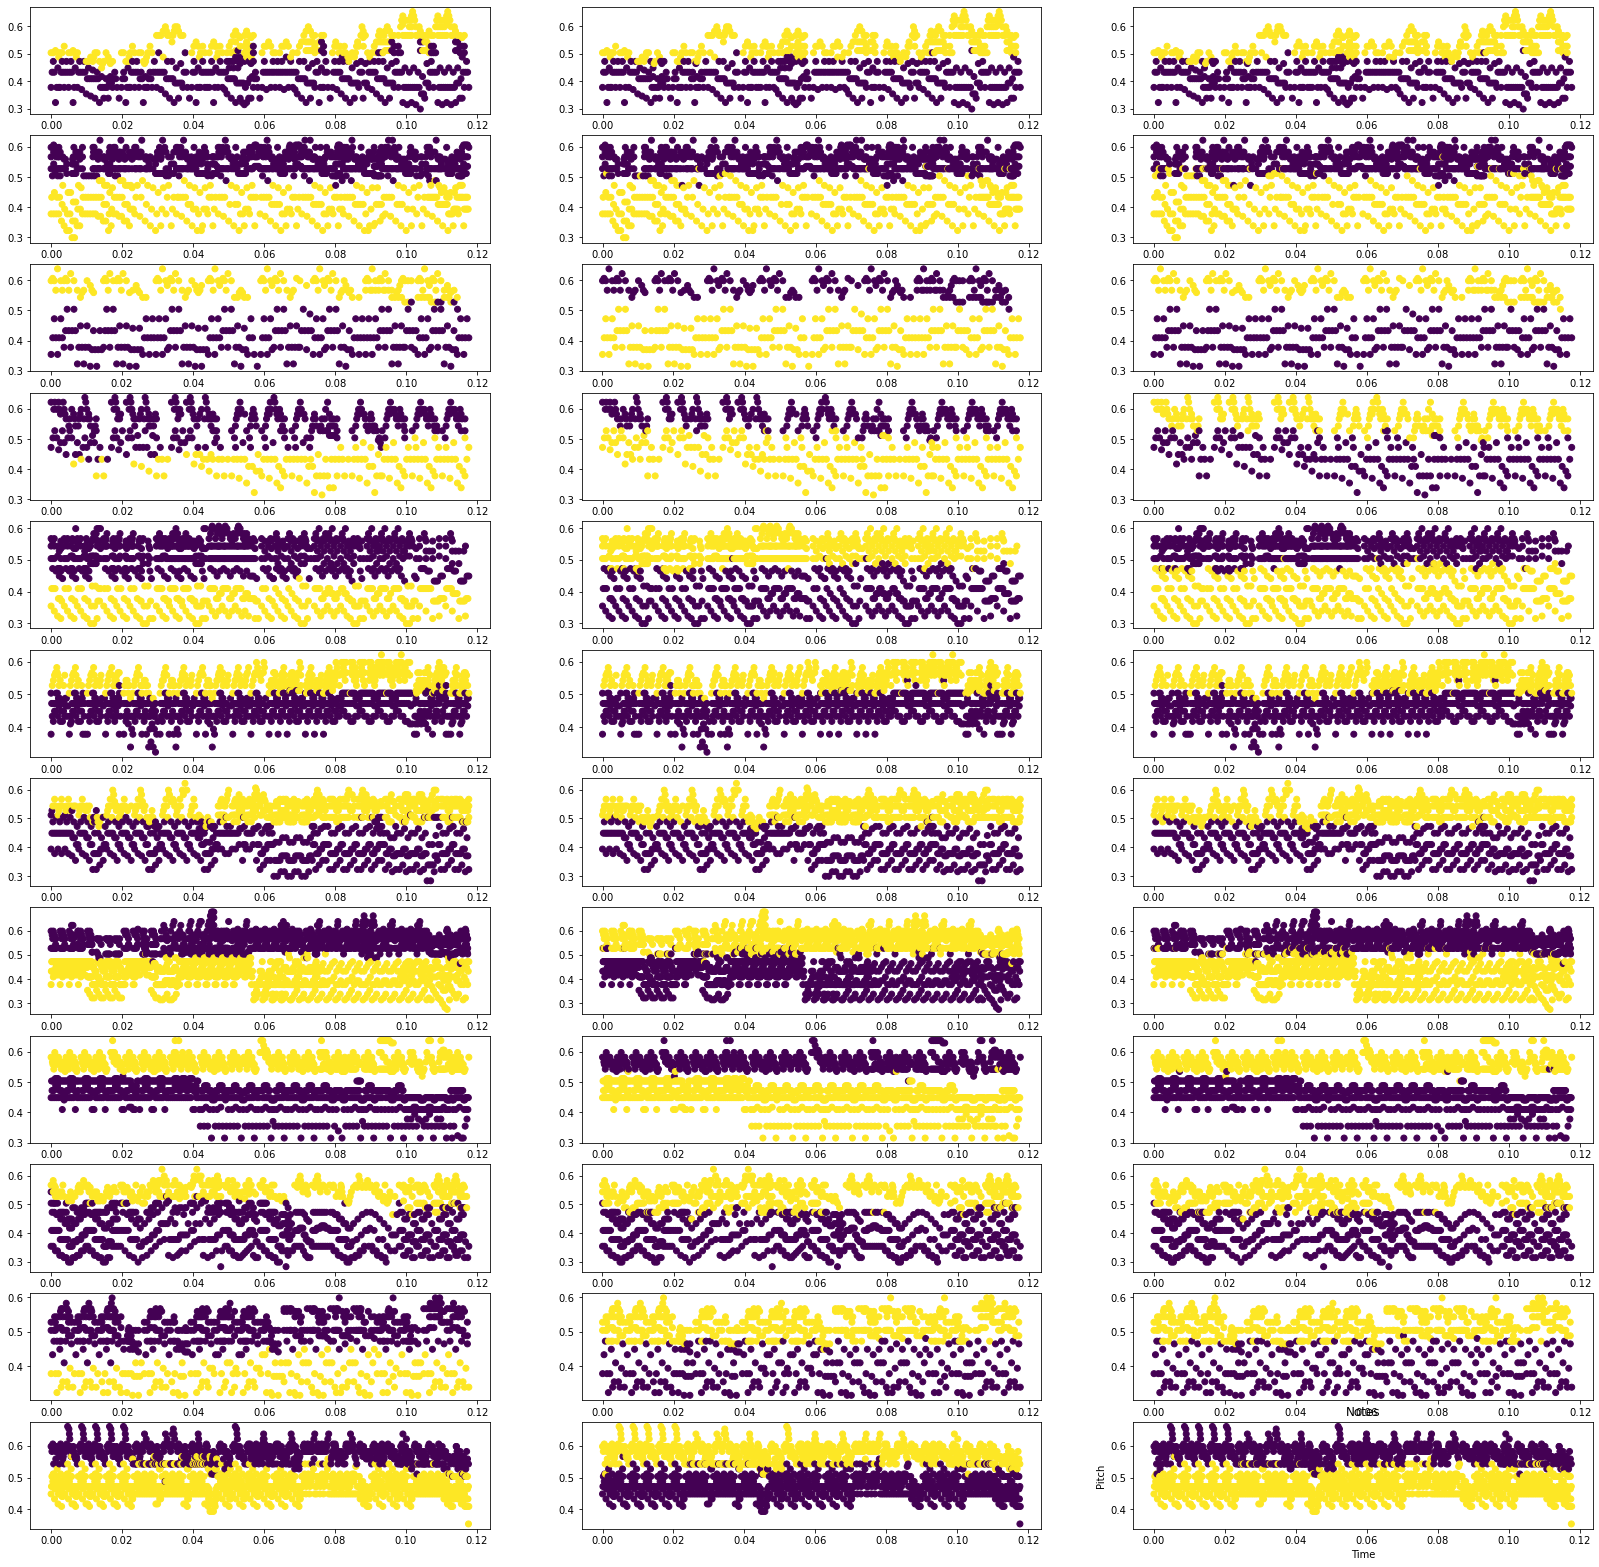

In [42]:
# test out a few different clustering algorithms on whole midi files
# set up scaling for axes
duration_scale=0.1
pitch_scale=1
velocity_scale=0.5

fig, ax = plt.subplots(nrows=len(files),ncols=3, figsize=(28,28))
# plt.yscale('log')
for i in tqdm(range(len(files))):
    pm = pretty_midi.PrettyMIDI(files[i].path)
    max_start = pm.instruments[0].notes[-1].start
        notes = np.array([[note.start / duration * duration_scale, note.pitch/127 * pitch_scale,
                       (note.velocity - 21) / 127 * velocity_scale] for note in pm.instruments[0].notes])
    kmeans = cluster.KMeans(n_clusters=2).fit(notes)
    spectral = cluster.SpectralClustering(n_clusters=2).fit(notes)
    ag = cluster.AgglomerativeClustering(2).fit(notes)
    
    ax[i,0].scatter([n[0] for n in notes], [n[1] for n in notes], c=ag.labels_)
    ax[i,1].scatter([n[0] for n in notes], [n[1] for n in notes], c=kmeans.labels_)
    ax[i,2].scatter([n[0] for n in notes], [n[1] for n in notes], c=spectral.labels_)
    plt.title('Notes')
    plt.xlabel('Time')
    plt.ylabel('Pitch')

(array([ 1.,  0.,  0.,  0.,  2.,  6.,  7., 12., 18., 24., 26., 35., 52.,
        58., 31., 47., 22., 39., 23., 18., 27., 16., 15., 10., 22., 20.,
        31., 12., 21.,  5., 18., 10.,  5., 16.,  4., 10.,  5.,  1.,  5.,
         1.]),
 array([-0.20454545, -0.18011364, -0.15568182, -0.13125   , -0.10681818,
        -0.08238636, -0.05795455, -0.03352273, -0.00909091,  0.01534091,
         0.03977273,  0.06420455,  0.08863636,  0.11306818,  0.1375    ,
         0.16193182,  0.18636364,  0.21079545,  0.23522727,  0.25965909,
         0.28409091,  0.30852273,  0.33295455,  0.35738636,  0.38181818,
         0.40625   ,  0.43068182,  0.45511364,  0.47954545,  0.50397727,
         0.52840909,  0.55284091,  0.57727273,  0.60170455,  0.62613636,
         0.65056818,  0.675     ,  0.69943182,  0.72386364,  0.74829545,
         0.77272727]),
 <a list of 40 Patch objects>)

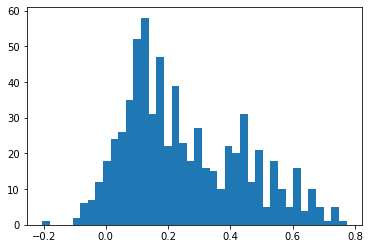

In [23]:
plt.hist([n[2] for n in notes], bins=20)